#### Plotting MPAS unstructured triangular grid on triangular grid 
- The triangulation is generated using Matplotlib's tri.Triangulation() 
- plotting the colored triangles using the pyplot.tripcolor() 
- projection: when creating plots and determining the projection of the resulting plot
- transform : tells Cartopy what coordinate system your data are defined in(ccrs.PlateCarree()) <br>
  the default assumption is that the coordinate system matches the projection
  
From Michael Duda:
https://www2.mmm.ucar.edu/projects/mpas/tutorial/Howard2024/ <br>
regional_cell.ncl
  
Ming Ge Feb 2025

In [1]:
import numpy as np
import xarray as xr
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 

import cartopy.feature as cfeature
import cartopy.crs as ccrs

- Open MPAS data and grid files   

In [2]:
dir_data = '/glade/derecho/scratch/duda/mpas_tutorial/240-48km_variable/'
flnm_grid = dir_data + 'SouthAmerica.static.nc' 
ds_data = xr.open_dataset(flnm_grid)
ds_grid = ds_data

varname = 'ivgtyp'

#-- Have a look at the different shapes.
print(f'vlon/vlat:      {ds_grid.lonCell.shape}, {ds_grid.latCell.shape}')
    
#-- Data and coordinates
# vlon, vla:  longitude, latitude of the triangle vertices in radians
vlon = ds_grid.lonCell
vlat = ds_grid.latCell

vlon/vlat:      (30210,), (30210,)


- read Variable data

In [3]:
var = ds_data[varname].squeeze()

-  Data range, colors, and labels

In [4]:
var_min = 1
var_max = 20
var_int = 1
    
levels = np.arange(var_min, var_max+var_int, var_int)
nlevs  = levels.size
labels = ['{:.2f}'.format(x) for x in levels]
    
print(f'levels: {levels}\nnumber of levels:  {nlevs:3d}')

levels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
number of levels:   20


- Triangulation: Python plot data on a triangular grid with tripcolor <br>
The triangulation is generated using Matplotlib's `tri.Triangulation()`<br>
pyplot.tripcolor() is used for plotting  the colored triangles

In [5]:
# The triangulation for plotting can be generated with Matplotlib's
# `tri.Triangulation()` class. It takes the longitude and latitude vertices,
# and the vertex of cell indices to compute the triangles.
#
# To avoid wrapping of the lines, a mask is also created here and assigned to
# the triangulation object with the set_mask() method. See also
# https://stackoverflow.com/questions/52457964/how-to-deal-with-the-undesired-triangles-that-form-between-the-edges-of-my-geo
 
triang    = tri.Triangulation(vlon.values.flatten(), vlat.values.flatten())
triangles = triang.triangles
    
# generate the mask
mlon = vlon.values.flatten()[triangles] - np.roll(vlon.values.flatten()[triangles], 1, axis=1)
mlat = vlat.values.flatten()[triangles] - np.roll(vlat.values.flatten()[triangles], 1, axis=1)
max_value = np.max(np.sqrt(mlon**2 + mlat**2), axis=1)
max_radius = 1
    
# assign mask to triang
triang.set_mask(max_value > max_radius)

- Plotting using projections <br>
If a projection other than `ccrs.PlateCarree()` is used,  the `ax.set_global()` <br>
or `ax.set_extent()` must be set and the transform=ccrs.PlateCarree() has to be added <br>
to the `ax.tripcolor()` call.  <br>

https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html

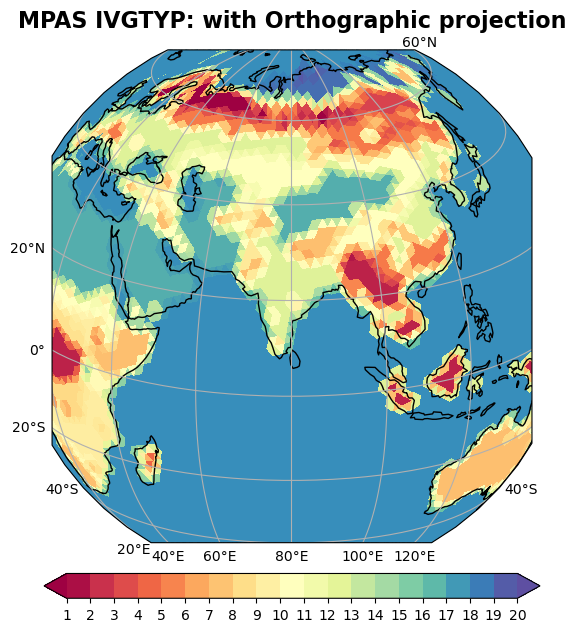

In [7]:
# Set the data CRS
lonW = 20
lonE = 140
latS = -40
latN = 80
cenlat = (latN + latS) / 2
cenlon = (lonW + lonE) / 2

triang2 = tri.Triangulation(np.rad2deg(vlon).values.flatten(), np.rad2deg(vlat).values.flatten())

triang2.set_mask(max_value > max_radius)

# The data are defined in lat/lon coordinate system, use PlateCarree()
data_crs = ccrs.PlateCarree()
    
#-- Orthographic
projection = ccrs.Orthographic(cenlon, cenlat)
    
# The projection keyword determines how the plot will look
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=projection))
    
#ax.set_global()    #-- has to be set
# set_extent use PlateCarree to ensure the values we passed into set_extent will be 
ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
    
# Manipulate gridlines number and spaces
gl.ylocator = mticker.FixedLocator(np.arange(int(latS), int(latN), 20))
gl.xlocator = mticker.FixedLocator(np.arange(int(lonW), int(lonE), 20)) 
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False

plot = ax.tripcolor(triang2, var.values, edgecolors='none', 
                cmap='Spectral',
                # color controls edge lines
                #color=colors,
                transform=ccrs.PlateCarree()
                )
    
# add a color bar
cb = plt.cm.ScalarMappable(cmap='Spectral',
                               norm=plt.Normalize(vmin=var_min, vmax=var_max))
cb.set_array([])
cbar = plt.colorbar(cb, ax=ax,  
                        orientation='horizontal',
                        ticks=levels,
                        boundaries=levels,
                        format='%0.0f',
                        shrink=0.8, # 0.7
                        pad=0.05, 
                        aspect=20, # Ratio of long to short dimensions.
                       extend = 'both')  

# Colorbar Tick Labelling    
cbar.ax.set_xticklabels(levels)
    
ax.set_title('MPAS IVGTYP: with Orthographic projection', fontsize=16, weight='bold');    

#### For Comparison: plot from original  PyNGL

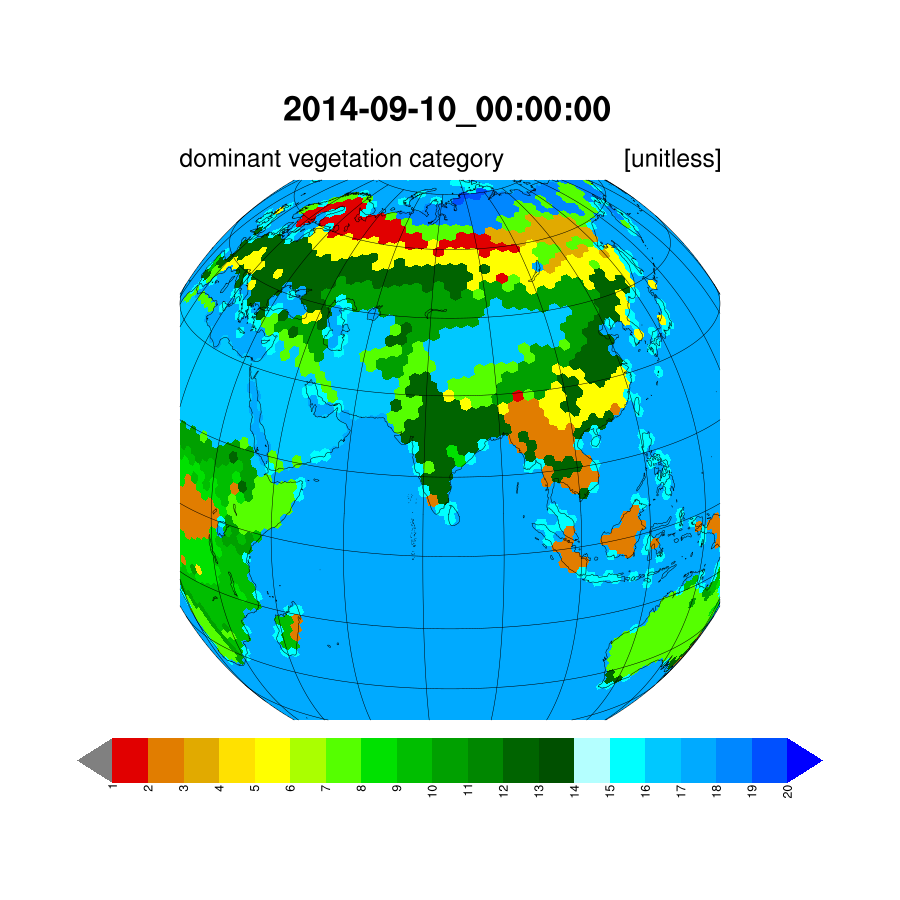

In [8]:
from IPython.display import Image
Image(filename=('/glade/u/home/mingge/NCL_2_PYTHON/cells.png'))